# Recommendation Systems_R5_Project1

# Recommendation system for products on an e-commerce website like Amazon.com.

### Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import time

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import pylab as pl

import seaborn as sns
sns.set(style="white")
sns.set(style="darkgrid", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

## Problem Statement :
## Build Popularity Recommender model and Collaborative Filtering model 

### Load data and read and analyze the data

In [2]:
data = pd.read_csv("ratings_Electronics.csv", names=['userId', 'productId', 'ratings', 'timestamp'])

In [3]:
data.shape

(7824482, 4)

In [4]:
data.dtypes

userId        object
productId     object
ratings      float64
timestamp      int64
dtype: object

In [5]:
data.head(5)

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
data.tail(5)

,userId,productId,ratings,timestamp
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0,1312675200


In [7]:
data.sample(5)

,userId,productId,ratings,timestamp
2611263,A1L0947MLDVZ2F,B002HU65EQ,5.0,1342915200
104500,A3F7UAJVO7T083,B00005MAAR,5.0,998179200
5599526,AMRTSM65JXZLI,B0074BW614,3.0,1364256000
3586133,A38B7DTWWL4JE,B003UT6C9G,3.0,1296691200
3746360,A3Q5QGL7MV7040,B0040GJIX0,5.0,1356652800


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [9]:
data.isna().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [10]:
(data.drop(['userId', 'productId'], axis=1) < 0).sum()

ratings      0
timestamp    0
dtype: int64

In [11]:
data.duplicated().sum()

0

In [12]:
data.drop('timestamp', axis=1, inplace=True)

### Exploratory Data Analysis (EDA)

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


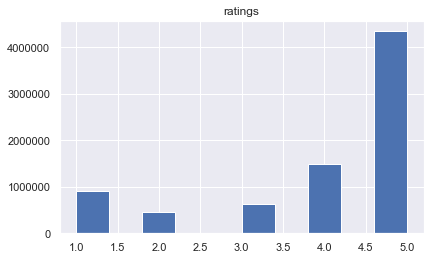

In [14]:
#Histogram of dataset
data.hist(bins=10, figsize=(15,9), layout=(2,2))
plt.show()

In [15]:
#unique users in the dataset
len(data['userId'].unique())

4201696

In [16]:
#unique products in the dataset
len(data['productId'].unique())

476002

In [17]:
#unique ratings in the dataset
len(data['ratings'].unique())

5

In [18]:
#value counts of ratings
data['ratings'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: ratings, dtype: int64

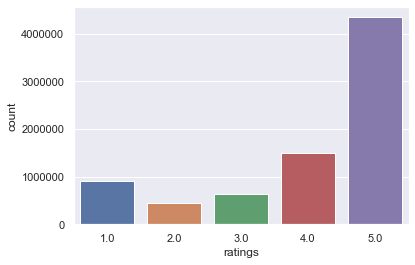

In [19]:
#countplot for ratings
sns.countplot(x='ratings',data=data)
plt.show()

#### Observations from countplot:
- maximum no of ratings is for 5.0 and minimum no of ratings is for 2.0

In [63]:
#mean ratings given by users
user_mean = pd.DataFrame(data.groupby(by='userId')['ratings'].mean())
user_mean['no_of_ratings'] = data.groupby(by='userId')['ratings'].count()
user_mean.head()

,ratings,no_of_ratings
userId,,
A00000262KYZUE4J55XGL,5.0,1
A000063614T1OE0BUSKUT,5.0,2
A00009182QVLSWIGHLS1B,5.0,1
A00009661LC9LQPGKJ24G,5.0,1
A00010809P09NUU6ZP6H,5.0,1


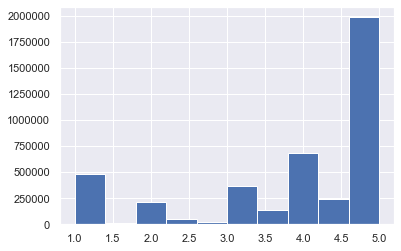

In [64]:
#Histogram for mean ratings given by users
user_mean['ratings'].hist(bins=10)
plt.show()

#### Observations from histogram :
- Histogram of mean ratings shows that most of the ratings given by users are between 3.0 and 5.0

In [65]:
#mean ratings given to products
product_mean = pd.DataFrame(data.groupby(by='productId')['ratings'].mean())
product_mean['no_of_ratings'] = data.groupby(by='productId')['ratings'].count()
product_mean.head()

,ratings,no_of_ratings
productId,,
0132793040,5.000000,1
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27


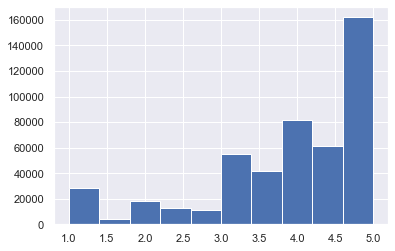

In [66]:
#Histogram for mean ratings given to products
product_mean['ratings'].hist(bins=10)
plt.show()

#### Observations from histogram :
- Histogram of mean ratings shows that most of the ratings given to products are between 3.0 and 5.0

In [24]:
#Count of users who has given 50 or more number of ratings
print("Number of users who have given 50 or more ratings :")
(data.groupby(by='userId')['ratings'].count() >= 50).sum()

Number of users who have given 50 or more ratings :


1540

In [25]:
user_ratings_count = pd.DataFrame(data.groupby(by='userId', as_index=False)['ratings'].count())

In [26]:
user_ratings_count.shape

(4201696, 2)

In [27]:
#Top 5 users who have given the maximum ratings for the products
user_ratings_count.sort_values(by='ratings', ascending=False).head(5)

,userId,ratings
3263531,A5JLAU2ARJ0BO,520
3512451,ADLVFFE4VBT8,501
2989526,A3OXHLG6DIBRW8,498
3291008,A6FIAB28IS79,431
3284634,A680RUE1FDO8B,406


In [28]:
#Create a subset of the dataset to make it less sparse/more dense.
#Keep only the users who have given 50 or more ratings to the products and ignore the rest
#Create a DataFrame with users who have given 50 or more ratings

df = data[data['userId'].isin(user_ratings_count.loc[(user_ratings_count['ratings']>=50), 'userId'])]

In [29]:
#Reset the index of the new DataFrame
df.reset_index(drop=True, inplace=True)

In [30]:
df.shape

(125871, 3)

In [31]:
df.head()

,userId,productId,ratings
0,A3BY5KCNQZXV5U,0594451647,5.0
1,AT09WGFUM934H,0594481813,3.0
2,A32HSNCNPRUMTR,0970407998,1.0
3,A17HMM1M7T9PJ1,0970407998,4.0
4,A3CLWR1UUZT6TG,0972683275,5.0


In [32]:
df.tail()

,userId,productId,ratings
125866,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
125867,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
125868,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
125869,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0
125870,A2BYV7S1QP2YIG,B00LKG1MC8,5.0


## Popularity based Recommender System

In [33]:
#Class for Popularity based Recommender System model

class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.userId = None
        self.productId = None
        self.n_recommendations = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    
    def create(self, train_data, userId, productId, n_recommendations):
        self.train_data = train_data
        self.userId = userId
        self.productId = productId
        self.n_recommendations = n_recommendations

        #Get a count of userIds for each unique product as recommendation score
        train_data_grouped = train_data.groupby([self.productId]).agg({self.userId: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
    
        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.productId], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(n_recommendations)

    #Use the popularity based recommender system model to make recommendations
    
    def recommend(self, userId):    
        user_recommendations = self.popularity_recommendations        
        #print(user_recommendations)
        
        #Add userId column for which the recommendations are being generated
        user_recommendations['userId'] = userId
        #print(user_recommendations['userId'])
        
        #Bring userId column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        #print(user_recommendations[cols])
        
        user_recommendations = user_recommendations[cols]
        return user_recommendations
    

In [34]:
#Top k Recommendations to be given where k=5
k=10

#Create instance of Popularity based Recommender system 
popularity_model = popularity_recommender_py()

In [35]:
popularity_model.create(df, 'userId', 'productId', k)

In [36]:
user_id = df.loc[128,'userId']
popularity_model.recommend(user_id)

,userId,productId,score,Rank
39003,A87N6UTYA6NOB,B0088CJT4U,206,1.0
24827,A87N6UTYA6NOB,B003ES5ZUU,184,2.0
11078,A87N6UTYA6NOB,B000N99BBC,167,3.0
38250,A87N6UTYA6NOB,B007WTAJTO,164,4.0
38615,A87N6UTYA6NOB,B00829TIEK,149,5.0
38611,A87N6UTYA6NOB,B00829THK0,137,6.0
39338,A87N6UTYA6NOB,B008DWCRQW,137,7.0
21982,A87N6UTYA6NOB,B002R5AM7C,128,8.0
28761,A87N6UTYA6NOB,B004CLYEDC,118,9.0
22210,A87N6UTYA6NOB,B002SZEOLG,113,10.0


In [37]:
user_id = df.loc[299,'userId']
popularity_model.recommend(user_id)

,userId,productId,score,Rank
39003,A2QI2NTDTMK2FV,B0088CJT4U,206,1.0
24827,A2QI2NTDTMK2FV,B003ES5ZUU,184,2.0
11078,A2QI2NTDTMK2FV,B000N99BBC,167,3.0
38250,A2QI2NTDTMK2FV,B007WTAJTO,164,4.0
38615,A2QI2NTDTMK2FV,B00829TIEK,149,5.0
38611,A2QI2NTDTMK2FV,B00829THK0,137,6.0
39338,A2QI2NTDTMK2FV,B008DWCRQW,137,7.0
21982,A2QI2NTDTMK2FV,B002R5AM7C,128,8.0
28761,A2QI2NTDTMK2FV,B004CLYEDC,118,9.0
22210,A2QI2NTDTMK2FV,B002SZEOLG,113,10.0


In [38]:
user_id = df.loc[6979,'userId']
popularity_model.recommend(user_id)

,userId,productId,score,Rank
39003,AZBXKUH4AIW3X,B0088CJT4U,206,1.0
24827,AZBXKUH4AIW3X,B003ES5ZUU,184,2.0
11078,AZBXKUH4AIW3X,B000N99BBC,167,3.0
38250,AZBXKUH4AIW3X,B007WTAJTO,164,4.0
38615,AZBXKUH4AIW3X,B00829TIEK,149,5.0
38611,AZBXKUH4AIW3X,B00829THK0,137,6.0
39338,AZBXKUH4AIW3X,B008DWCRQW,137,7.0
21982,AZBXKUH4AIW3X,B002R5AM7C,128,8.0
28761,AZBXKUH4AIW3X,B004CLYEDC,118,9.0
22210,AZBXKUH4AIW3X,B002SZEOLG,113,10.0


#### Observations on Popularity Based Recommender System model:
-  The Popularity recommender modelv recommended the best products based on poularity of the product.

## Collaborative Filtering Based Recommendation System

In [39]:
#Take only 10% of the reduced datset data_df as we will encounter a memory error if we take the complete dataset

x = round((df.shape[0])*10/100)
df_new = df.iloc[0:x,:]
df_new.shape

(12587, 3)

In [40]:
df_new.head()

,userId,productId,ratings
0,A3BY5KCNQZXV5U,0594451647,5.0
1,AT09WGFUM934H,0594481813,3.0
2,A32HSNCNPRUMTR,0970407998,1.0
3,A17HMM1M7T9PJ1,0970407998,4.0
4,A3CLWR1UUZT6TG,0972683275,5.0


In [41]:
#Import the require classes from surprise library

from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split

In [42]:
#Load the dataset

reader = Reader(rating_scale=(1, 5))
df2 = Dataset.load_from_df(df_new, reader)

In [43]:
df2.df.shape

(12587, 3)

In [44]:
df2.df.head()

,userId,productId,ratings
0,A3BY5KCNQZXV5U,0594451647,5.0
1,AT09WGFUM934H,0594481813,3.0
2,A32HSNCNPRUMTR,0970407998,1.0
3,A17HMM1M7T9PJ1,0970407998,4.0
4,A3CLWR1UUZT6TG,0972683275,5.0


In [45]:
#Split the data into train and test dataset in the ratio 70:30
trainset, testset = train_test_split(df2, test_size=0.30, random_state=7)

In [46]:
print('Size of trainset: {}\nSize of testset: {}'.format(trainset.n_items, len(testset)))

Size of trainset: 5054
Size of testset: 3777


In [47]:
#Creating an instance of Item Similarity based Collaborative Filtering model
#Use user_based true/false to switch between user-based or item-based collaborative filtering
item_sim_model = KNNWithMeans(k=50, min_k=1, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [48]:
#Fit the model on trainset
item_sim_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [49]:
#Run the model on testset
item_sim_pred = item_sim_model.test(testset)

In [50]:
item_sim_pred[0:5]

[Prediction(uid='A1522TN5FVJL0Y', iid='B00004Z5M1', r_ui=5.0, est=4.818181818181818, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B0000UUXB6', r_ui=3.0, est=4.263677639046538, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3OA4DV4L81N1D', iid='B00009KH63', r_ui=4.0, est=3.2857142857142856, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B000053HH5', r_ui=5.0, est=4.833333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2OKRGHIYTBQ6P', iid='B00076RJV0', r_ui=1.0, est=4.666666666666667, details={'actual_k': 0, 'was_impossible': False})]

In [51]:
item_df = pd.DataFrame(([[x.uid,x.iid,x.est] for x in item_sim_pred]),
                                     columns=["userId","productId","est_rating"])

In [52]:
item_df.head()

,userId,productId,est_rating
0,A1522TN5FVJL0Y,B00004Z5M1,4.818182
1,A5JLAU2ARJ0BO,B0000UUXB6,4.263678
2,A3OA4DV4L81N1D,B00009KH63,3.285714
3,A25C2M3QF9G7OQ,B000053HH5,4.833333
4,A2OKRGHIYTBQ6P,B00076RJV0,4.666667


In [53]:
#top 5 recommendations using Item Similarity model
top_5_recos = item_df.groupby("userId").head(5).reset_index(drop=True)
top_5_recos

,userId,productId,est_rating
0,A1522TN5FVJL0Y,B00004Z5M1,4.818182
1,A5JLAU2ARJ0BO,B0000UUXB6,4.263678
2,A3OA4DV4L81N1D,B00009KH63,3.285714
3,A25C2M3QF9G7OQ,B000053HH5,4.833333
4,A2OKRGHIYTBQ6P,B00076RJV0,4.666667
5,A3872Y2XH0YDX1,B0002CPBUK,4.263678
6,A2XQYE6TJYROHQ,B0002J27OQ,4.263678
7,A2XU6J41ZQOJ2V,B00006L3CM,4.263678
8,A1UQUDT2Q0YENM,B00066IJPQ,3.363636
9,A2ZR3YTMEEIIZ4,B00067TTY0,3.000000


In [54]:
#Evaluating Item Similarity model
#get RMSE value for the model

print("\nRMSE for Item-Similarity based Model :")
accuracy.rmse(item_sim_pred, verbose=True)


RMSE for Item-Similarity based Model :
RMSE: 1.2151


1.2150899560041033

In [55]:
#Creating an instance of User Similarity based Collaborative Filtering model
#Use user_based true/false to switch between user-based or item-based collaborative filtering
user_sim_model = KNNWithMeans(k=50, min_k=1, sim_options={'name': 'pearson_baseline', 'user_based': True})

In [56]:
#Fit the model on trainset
user_sim_model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [57]:
#Run the model on testset
user_pred = user_sim_model.test(testset)

In [58]:
user_pred[0:5]

[Prediction(uid='A1522TN5FVJL0Y', iid='B00004Z5M1', r_ui=5.0, est=4.7272727272727275, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B0000UUXB6', r_ui=3.0, est=4.263677639046538, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3OA4DV4L81N1D', iid='B00009KH63', r_ui=4.0, est=1.5999999999999996, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A25C2M3QF9G7OQ', iid='B000053HH5', r_ui=5.0, est=4.9, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2OKRGHIYTBQ6P', iid='B00076RJV0', r_ui=1.0, est=5, details={'actual_k': 0, 'was_impossible': False})]

In [59]:
user_df = pd.DataFrame(([[x.uid,x.iid,x.est] for x in user_pred]),
                                     columns=["userId","productId","est_rating"])

In [60]:
user_df.head()

,userId,productId,est_rating
0,A1522TN5FVJL0Y,B00004Z5M1,4.727273
1,A5JLAU2ARJ0BO,B0000UUXB6,4.263678
2,A3OA4DV4L81N1D,B00009KH63,1.600000
3,A25C2M3QF9G7OQ,B000053HH5,4.900000
4,A2OKRGHIYTBQ6P,B00076RJV0,5.000000


In [61]:
#top 5 recommendations using User Similarity model
top_5_recos = user_df.groupby("userId").head(5).reset_index(drop=True)
top_5_recos

,userId,productId,est_rating
0,A1522TN5FVJL0Y,B00004Z5M1,4.727273
1,A5JLAU2ARJ0BO,B0000UUXB6,4.263678
2,A3OA4DV4L81N1D,B00009KH63,1.600000
3,A25C2M3QF9G7OQ,B000053HH5,4.900000
4,A2OKRGHIYTBQ6P,B00076RJV0,5.000000
5,A3872Y2XH0YDX1,B0002CPBUK,4.263678
6,A2XQYE6TJYROHQ,B0002J27OQ,4.263678
7,A2XU6J41ZQOJ2V,B00006L3CM,4.263678
8,A1UQUDT2Q0YENM,B00066IJPQ,2.000000
9,A2ZR3YTMEEIIZ4,B00067TTY0,3.925926


In [62]:
#Evaluating User Similarity based model
#get RMSE value for the model
print("\nRMSE for User-Similarity based Model :")
accuracy.rmse(user_pred, verbose=True)


RMSE for User-Similarity based Model :
RMSE: 1.1349


1.134880939070227

#### Observations on Item and User based models:
- The RMSE of Item-based Similarity approach is 1.22 for a neighborhhod size of 50 using the KNNWithMeans algorithm and Pearson-Correlation Similarity measure
- The RMSE of User-based Similarity approach is 1.013 for a neighborhhod size of 50 using the KNNWithMeans algorithm and Pearson-Correlation Similarity measure
- RMSE of Item Similarity based approach is more compared to User Similarity based approach